# Advanced ANNs: Transfer Learning (Transfer)

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import copy
import metpy
import metpy.calc

2024-03-28 10:15:31.788790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 10:15:32.275483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# we will set the seed this time to ensure fairness
tf.random.set_seed(1)

In [2]:
al_asos = pd.read_csv("../Week_6/al_asos_jul_23_v2.csv")
#us_asos = pd.read_csv("/share/share/combined_asos_2023.csv")
#us_asos = pd.read_csv("/home/sfreeman/teaching/sp24/combined_asos_2023.csv")

In [3]:
def nws_heat_index(T, RH):
    '''
    T in fahrenheit, RH in %
    https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    '''
    initial_hi =  0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
    if initial_hi < 80:
        return initial_hi

    adjustment_factor = 0
    if T>=80 and T<=112 and RH <13:
        adjustment_factor =  ((13-RH)/4)*np.sqrt((17-np.abs(T-95.))/17)
    
    if T>=80 and T<=87 and RH > 85:
         adjustment_factor = ((RH-85)/10) * ((87-T)/5)

    return (-42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - 
           .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH) + adjustment_factor

nws_heat_index_vectorized = np.vectorize(nws_heat_index)

In [4]:
al_asos

,station,valid,tmpf,tmpc,dwpf,dwpc,relh,feel,sknt,mslp,p01m,p01i,gust,skyc1,skyl1
0,HEY,2023-07-01 00:11,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.0,0.0000,0.0000,NaN,CLR,NaN
1,SXS,2023-07-01 00:12,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.6,0.0000,0.0000,NaN,CLR,NaN
2,HUA,2023-07-01 00:14,89.6,32.00,77.0,25.00,66.55,102.54,5.0,1013.9,0.0000,0.0000,NaN,FEW,4700.0
3,8A0,2023-07-01 00:15,86.0,30.00,73.4,23.00,66.15,93.45,0.0,NaN,0.0000,0.0000,NaN,CLR,NaN
4,4A6,2023-07-01 00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64232,EKY,2023-07-30 23:56,79.0,26.11,76.0,24.44,90.55,79.00,0.0,1001.8,0.0000,0.0000,NaN,CLR,NaN
64233,79J,2023-07-30 23:56,76.0,24.44,73.0,22.78,90.44,76.00,4.0,1015.6,0.0000,0.0000,NaN,CLR,NaN
64234,SXS,2023-07-30 23:56,73.4,23.00,73.4,23.00,100.00,73.40,0.0,1015.1,0.0000,0.0000,NaN,FEW,500.0
64235,EUF,2023-07-30 23:58,79.0,26.11,75.0,23.89,87.58,79.00,0.0,1014.3,0.0000,0.0000,NaN,CLR,NaN


In [5]:
al_asos['heat_index'] = nws_heat_index_vectorized(al_asos["tmpf"], al_asos['relh'])

/home/sfreeman/miniforge3/envs/aes690st_sp24/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in nws_heat_index (vectorized)
  outputs = ufunc(*inputs)


<Axes: >

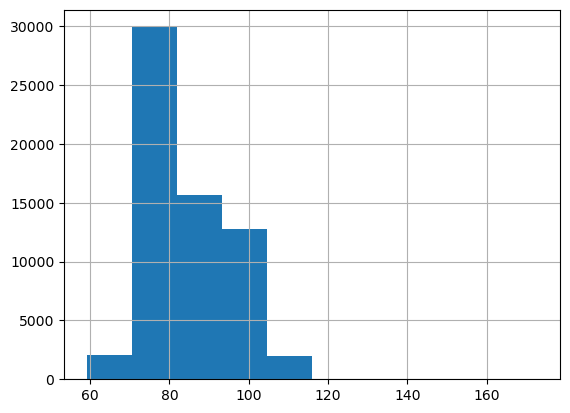

In [6]:
al_asos['heat_index'].hist()

In [10]:
model_us = keras.models.load_model("./my_usa_model.keras")

2024-03-28 10:16:44.978612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 10:16:45.000293: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
model_us.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,642 (3.07 MB)

 Trainable params: 268,545 (1.02 MB)

 Non-trainable params: 5 (24.00 B)

 Optimizer params: 537,092 (2.05 MB)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
al_asos_nona = al_asos.dropna(subset=['tmpf', 'relh', 'heat_index'])

In [14]:
# Prepare our data first

training_data_AL, test_validation_AL = train_test_split(al_asos_nona, test_size=0.25)
testing_data_AL, validation_data_AL = train_test_split(test_validation_AL, test_size=0.5)

In [47]:
model_no_last_layer = keras.models.Model(model_us.input, model_us.layers[-2].output)
model_no_last_layer.trainable=False

In [48]:
tf.keras.backend.clear_session()

input1 = keras.layers.Input(shape=(2, ))
original_model = model_no_last_layer(input1, training=False)
new_dense = keras.layers.Dense(32, activation=keras.activations.elu)(original_model)

output = keras.layers.Dense(1, activation=None, use_bias=True)(new_dense)
model_AL = keras.models.Model(inputs=[input1], outputs=[output])
model_AL.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
model_AL.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 128)            │       268,421 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,582 (1.04 MB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 268,421 (1.02 MB)

In [49]:
model_AL.fit(training_data_AL[['tmpf', 'relh']].values, 
           training_data_AL['heat_index'].values, epochs=3, batch_size=128, shuffle=True )

Epoch 1/3


367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1605.0392
Epoch 2/3
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1850
Epoch 3/3
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7534


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


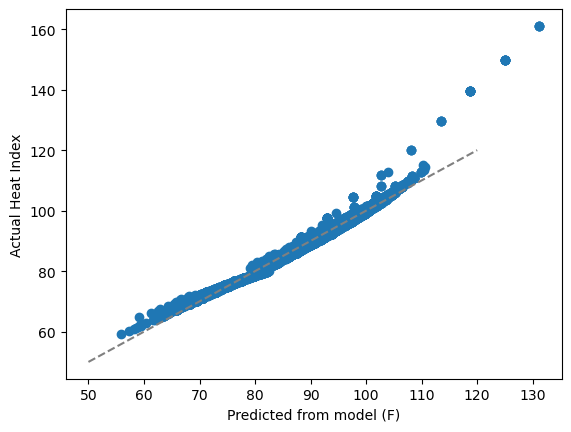

In [51]:
predicted_hi = model_AL.predict(testing_data_AL[['tmpf', 'relh']].values)
plt.scatter(predicted_hi, testing_data_AL['heat_index'])
plt.xlabel("Predicted from model (F)")
plt.ylabel("Actual Heat Index")
#plt.xlim(50, 120)
#plt.ylim(50, 120)
plt.plot([50, 120], [50, 120], color='grey', ls='--')

In [42]:
model_US.save("my_usa_model.keras")